In [0]:
from google.colab import files
import itertools
import random
from PIL import Image
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils as utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [0]:
!nvidia-smi

Sun Dec 22 11:45:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#!gdown https://drive.google.com/uc?id=1HYxzWzPvo4MBYL0JU79xJLg9zeBvha5A
!gdown https://drive.google.com/uc?id=1H5DAXcplYWuxi2uwB3UCY-rqd-WxcHTw
!unzip OP56.zip

Downloading...
From: https://drive.google.com/uc?id=1H5DAXcplYWuxi2uwB3UCY-rqd-WxcHTw
To: /content/OP56.zip
1.37GB [00:13, 99.8MB/s]
Archive:  OP56.zip
replace OP56/Colored/Colored/002 (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [0]:
# tf1=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# tf2=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# #tf=transforms.Compose([transforms.ToTensor()])
# color_dset=datasets.ImageFolder(root='/content/58/ColoredR',transform=tf1)
# noncolor_dset=datasets.ImageFolder(root='/content/58/NonColoredR',transform=tf2)

In [0]:
tf=transforms.Compose([transforms.Resize((128,128),Image.BICUBIC),transforms.RandomHorizontalFlip(),\
                       transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
color_dset=datasets.ImageFolder(root='/content/OP56/Colored',transform=tf)
noncolor_dset=datasets.ImageFolder(root='/content/OP56/NonColored',transform=tf)

In [0]:
class StackDataset(torch.utils.data.Dataset):
  def __init__(self,*datasets):
    self.datasets=datasets
    self.d1=datasets[0]
    self.d2=datasets[1]
  def __getitem__(self,i):
    return self.d1[i],self.d2[i]
  def __len__(self):
    return min(len(d) for d in self.datasets)

In [0]:
dset=StackDataset(noncolor_dset,color_dset)
dataloader=utils.data.DataLoader(dset,batch_size=1,shuffle=True,num_workers=1)
#color_loader=utils.data.DataLoader(color_dset,batch_size=16,shuffle=False)
#noncolor_loader=utils.data.DataLoader(noncolor_dset,batch_size=16,shuffle=False)

In [0]:
# real_batch=next(iter(color_loader))
# plt.figure(figsize=(24,24))
# plt.axis("off")
# plt.title("Colored JoJo")
# plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# real_batch = next(iter(noncolor_loader))
# plt.figure(figsize=(16,16))
# plt.axis("off")
# plt.title("Noncolored JoJo")
# plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Conv')!=-1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm2d')!=-1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [0]:
nc=3

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(nc,64,4,2,1),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64,128,4,2,1),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(128,256,4,2,1),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(256,512,4,2,1),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(512,1,4,padding=1)
    )
  def forward(self,x):
    x=self.layers(x)
    #return x
    return F.avg_pool2d(x,x.size()[2:]).view(x.size()[0])

In [0]:
class ResBlock(nn.Module):
  def __init__(self):
    super(ResBlock,self).__init__()
    self.layers=nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256,256,3),
        nn.ReflectionPad2d(1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256,256,3)
    )
  def forward(self,x):
    return x+self.layers(x)

In [0]:
class Generator(nn.Module):
  def __init__(self,num_blocks=9):
    super(Generator,self).__init__()
    model=[
           nn.ReflectionPad2d(3),
           nn.Conv2d(nc,64,7),
           nn.InstanceNorm2d(64),
           nn.ReLU(inplace=True)
    ]
    model+=[
            nn.Conv2d(64,128,3,stride=2,padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,256,3,stride=2,padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
    ]
    for _ in range(num_blocks):
      model+=[ResBlock()]

    model+=[
            nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
    ]
    model+=[
            nn.ReflectionPad2d(3),
            nn.Conv2d(64,nc,7),
            nn.Tanh()
    ]

    self.layers=nn.Sequential(*model)

  def forward(self,x):
    return self.layers(x)

In [0]:
g_a2b=Generator().to(device)
g_a2b.apply(weights_init_normal)
g_b2a=Generator().to(device)
g_b2a.apply(weights_init_normal)
d_a=Discriminator().to(device)
d_a.apply(weights_init_normal)
d_b=Discriminator().to(device)
d_b.apply(weights_init_normal)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [0]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


In [0]:
num_epochs=200

In [0]:
criterion_GAN=torch.nn.MSELoss()
criterion_cycle=torch.nn.L1Loss()
criterion_identity=torch.nn.L1Loss()

optimizer_g=torch.optim.Adam(itertools.chain(g_a2b.parameters(),g_b2a.parameters()),lr=0.0002,betas=(0.5,0.999))
optimizer_d_a=torch.optim.Adam(d_a.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer_d_b=torch.optim.Adam(d_b.parameters(),lr=0.0002,betas=(0.5,0.999))

# lr_scheduler_g=torch.optim.lr_scheduler.ExponentialLR(optimizer_g, gamma=0.05,last_epoch=-1)
# lr_scheduler_d_a=torch.optim.lr_scheduler.ExponentialLR(optimizer_d_a,gamma=0.1,last_epoch=-1)
# lr_scheduler_d_b=torch.optim.lr_scheduler.ExponentialLR(optimizer_d_b,gamma=0.1,last_epoch=-1)

lr_scheduler_g=torch.optim.lr_scheduler.LambdaLR(optimizer_g, lr_lambda=LambdaLR(200,0,100).step)
lr_scheduler_d_a=torch.optim.lr_scheduler.LambdaLR(optimizer_d_a, lr_lambda=LambdaLR(200,0,100).step)
lr_scheduler_d_b=torch.optim.lr_scheduler.LambdaLR(optimizer_d_b, lr_lambda=LambdaLR(200,0,100).step)

bsz=1
target_real=torch.ones(bsz).to(device)
target_fake=torch.zeros(bsz).to(device)

fake_a_buffer=ReplayBuffer()
fake_b_buffer=ReplayBuffer()

In [0]:
#Training

for epoch in range(1,num_epochs+1):
  for i,data in enumerate(dataloader,0):
    real_a=data[0][0].to(device)
    real_b=data[1][0].to(device)

    optimizer_g.zero_grad()

    #Identity Loss
    same_a=g_b2a(real_a)
    loss_identity_a=criterion_identity(same_a,real_a)*5.0
    same_b=g_a2b(real_b)
    loss_identity_b=criterion_identity(same_b,real_b)*5.0

    #GAN Loss
    fake_b=g_a2b(real_a)
    pred_fake=d_b(fake_b)
    loss_GAN_a2b=criterion_GAN(pred_fake,target_real)
    fake_a=g_b2a(real_b)
    pred_fake=d_a(fake_a)
    loss_GAN_b2a=criterion_GAN(pred_fake,target_real)

    #Cycle Loss
    recovered_a=g_b2a(fake_b)
    loss_cycle_aba=criterion_cycle(recovered_a,real_a)*10.0
    recovered_b=g_a2b(fake_a)
    loss_cycle_bab=criterion_cycle(recovered_b,real_b)*10.0

    #Total loss
    loss_g=loss_identity_a+loss_identity_b+loss_GAN_a2b+loss_GAN_b2a+loss_cycle_aba+loss_cycle_bab
    loss_g.backward()
    optimizer_g.step()

    optimizer_d_a.zero_grad()

    pred_real=d_a(real_a)
    loss_d_real=criterion_GAN(pred_real,target_real)
    # Fake loss
    fake_a=fake_a_buffer.push_and_pop(fake_a)
    pred_fake=d_a(fake_a.detach())
    loss_d_fake=criterion_GAN(pred_fake,target_fake)
    # Total loss
    loss_d_a=(loss_d_real+loss_d_fake)*0.5
    loss_d_a.backward()
    optimizer_d_a.step()

    optimizer_d_b.zero_grad()

    pred_real=d_b(real_b)
    loss_d_real=criterion_GAN(pred_real,target_real)
        
    # Fake loss
    fake_b=fake_b_buffer.push_and_pop(fake_b)
    pred_fake=d_b(fake_b.detach())
    loss_d_fake=criterion_GAN(pred_fake,target_fake)

    # Total loss
    loss_d_b=(loss_d_real+loss_d_fake)*0.5
    loss_d_b.backward()

    optimizer_d_b.step()

    if i%500==0:
      print('[%d/%d][%d/%d]\tloss_d_a: %.5f\tloss_d_b: %.5f\tloss_g: %.5f'
      % (epoch, num_epochs, i, len(dataloader),
      loss_d_a.item(),loss_d_b.item(),loss_g.item()))

  lr_scheduler_g.step()
  lr_scheduler_d_a.step()
  lr_scheduler_d_a.step()

  if epoch%20==0:
    torch.save(g_a2b.state_dict(),'g_a2b.pth')
    torch.save(g_b2a.state_dict(),'g_b2a.pth')
    torch.save(d_a.state_dict(),'d_a.pth')
    torch.save(d_b.state_dict(),'d_b.pth')

[1/200][0/1018]	loss_d_a: 0.49942	loss_d_b: 0.57372	loss_g: 26.54042
[1/200][500/1018]	loss_d_a: 0.38739	loss_d_b: 0.39917	loss_g: 5.94155
[1/200][1000/1018]	loss_d_a: 0.21690	loss_d_b: 0.16504	loss_g: 4.84602
[2/200][0/1018]	loss_d_a: 0.27700	loss_d_b: 0.15195	loss_g: 4.30257
[2/200][500/1018]	loss_d_a: 0.13662	loss_d_b: 0.11240	loss_g: 7.03288
[2/200][1000/1018]	loss_d_a: 0.34939	loss_d_b: 0.22308	loss_g: 4.73126
[3/200][0/1018]	loss_d_a: 0.09657	loss_d_b: 0.24307	loss_g: 5.05361
[3/200][500/1018]	loss_d_a: 0.18016	loss_d_b: 0.30692	loss_g: 4.01853
[3/200][1000/1018]	loss_d_a: 0.21343	loss_d_b: 0.31785	loss_g: 4.81631
[4/200][0/1018]	loss_d_a: 0.14426	loss_d_b: 0.36269	loss_g: 3.00940
[4/200][500/1018]	loss_d_a: 0.19641	loss_d_b: 0.05808	loss_g: 5.27439
[4/200][1000/1018]	loss_d_a: 0.17130	loss_d_b: 0.46004	loss_g: 3.70026
[5/200][0/1018]	loss_d_a: 0.40388	loss_d_b: 0.27647	loss_g: 2.67815
[5/200][500/1018]	loss_d_a: 0.14960	loss_d_b: 0.19487	loss_g: 4.00438
[5/200][1000/1018]	loss_d

KeyboardInterrupt: ignored

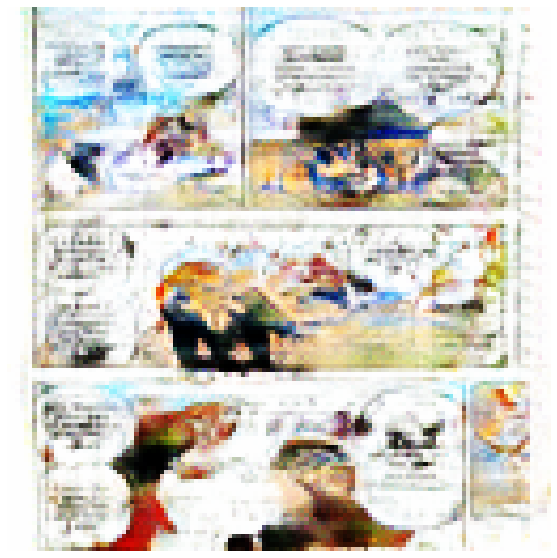

In [0]:
real_batch=next(iter(dataloader))
a=real_batch[0][0].to(device)
b=g_a2b(a).detach().cpu()
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(b[:].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('foo.jpg',bbox_inches='tight',dpi=1200,quality=90)

In [0]:
#model.load_state_dict(state_dict)
state_dict=torch.load('d_a.pth')
d_a.load_state_dict(state_dict)
state_dict=torch.load('d_b.pth')
d_b.load_state_dict(state_dict)
state_dict=torch.load('g_a2b.pth')
g_a2b.load_state_dict(state_dict)
state_dict=torch.load('g_b2a.pth')
g_b2a.load_state_dict(state_dict)

<All keys matched successfully>